(256, 256)


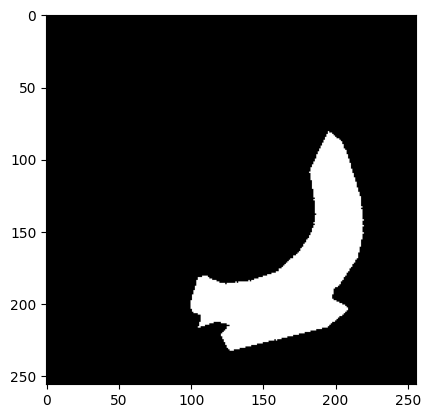

In [2]:
from sklearn.feature_extraction import image
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.transforms import ToTensor


x = Image.open('../dataset/bottle/ground_truth/broken_large/000_mask.png').resize((256,256)).convert('1')
print(np.array(x).shape)
plt.imshow(x)

In [4]:
# input image shape must be (1, 3, imsize, imsize)
# output will be (n_patches, 3, dim_patch, dim_patch)
from torch import Tensor
def extract_mask_patches(image:Tensor, dim=64, stride=32):
    patches = image.unfold(2, dim, stride).unfold(3, dim, stride)
    patches = patches.reshape(1, 1, -1, dim, dim)
    patches = patches.squeeze()
    #patches = torch.permute(patches, (1,0,2,3))
    return patches

def extract_patches(image:Tensor, dim=64, stride=32):
    patches = image.unfold(2, dim, stride).unfold(3, dim, stride)
    patches = patches.reshape(1, 3, -1, dim, dim)
    patches = patches.squeeze()
    patches = torch.permute(patches, (1,0,2,3))
    return patches

img = ToTensor()(x)
img = img.unsqueeze(0)
print(img.shape)
p = extract_mask_patches(img, 64, 64)
#p = torch.permute(p, (0, 2,3,1))
print(p.shape)

torch.Size([1, 1, 256, 256])
torch.Size([16, 64, 64])


In [10]:
stride = 64
dim = 64

# patches = image.extract_patches_2d(np.array(x), (64, 64), max_patches=8)
img = ToTensor()(x)
img = img.unsqueeze(0)
print(img.shape)
patches = img.unfold(2, dim, stride).unfold(3, dim, stride)
print(patches.shape)
patches = patches.reshape(1, 3, -1, dim, dim)
print(patches.shape)
patches = patches.squeeze()
print(patches.shape)
patches = torch.permute(patches, (1,0,2,3))
print(patches.shape)
patches = torch.permute(patches, (0, 3,2,1))
print(patches.shape)

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 4, 4, 64, 64])
torch.Size([1, 3, 16, 64, 64])
torch.Size([3, 16, 64, 64])
torch.Size([16, 3, 64, 64])
torch.Size([16, 64, 64, 3])


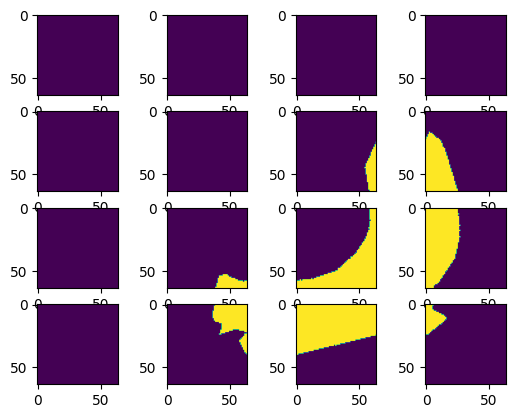

In [12]:
fig, ax = plt.subplots(4,4)
k = 0
for i in range(4):
    for j in range(4):
        ax[i][j].imshow(np.array(p[k]))
        k += 1